## Predicting the Genre of Books from Summaries


### Table of Contents

1. [Necessary Imports](#imports)
2. [Data Prepartion](#Preparation)
3. [Feature Exaction](#Exaction)
4. [Model Training](#Training)
5. [Model Evaluation](#Evaluation) 
  

## 1.Necessary Libraries Imports
<a id="imports"></a>

In [1]:
## Necessary librabiry 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from wordcloud import WordCloud, STOPWORDS
## NLTK lib 

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
import nltk
nltk.download('punkt')

from nltk import word_tokenize,sent_tokenize

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

## Model - sklearn 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from nltk.stem import SnowballStemmer
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc,roc_auc_score,make_scorer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
#Classification Area under curve
import warnings
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


warnings.filterwarnings('ignore')
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\melis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\melis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\melis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select suitable models to classify them. You should build and evaluate at least TWO models and compare the prediction results.

You should report on each stage of your experiment as you work with the data.


## 2.Data Preparation
<a id="Preparation"></a>

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [2]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [3]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape


(8954, 5)

In [4]:
genre_books.head()

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy


In [5]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()


,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


## 3.Feature Exaction
<a id="Exaction"></a>


Now you take over to build a suitable model and present your results.

Firstly, you need to perform feature extraction to produce feature vectors for the predictive models.

In [6]:
genre_books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8954 entries, 0 to 16549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    8954 non-null   object
 1   author   8954 non-null   object
 2   date     8954 non-null   object
 3   summary  8954 non-null   object
 4   genre    8954 non-null   object
dtypes: object(5)
memory usage: 419.7+ KB


In [7]:
genre_books.describe()

,title,author,date,summary,genre
count,8954,8954,8954,8954,8954
unique,8869,2698,1920,8934,5
top,Betrayal,,,~Plot outline description~ --> <!--,Fantasy
freq,3,447,2070,12,2311


In [38]:
# Check missing value
genre_books.isnull()

,title,author,date,summary,genre,genre_dummy
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
4,False,False,False,False,False,False
6,False,False,False,False,False,False
...,...,...,...,...,...,...
16525,False,False,False,False,False,False
16526,False,False,False,False,False,False
16531,False,False,False,False,False,False
16532,False,False,False,False,False,False


#### The dataset genre_books are not NAN values 

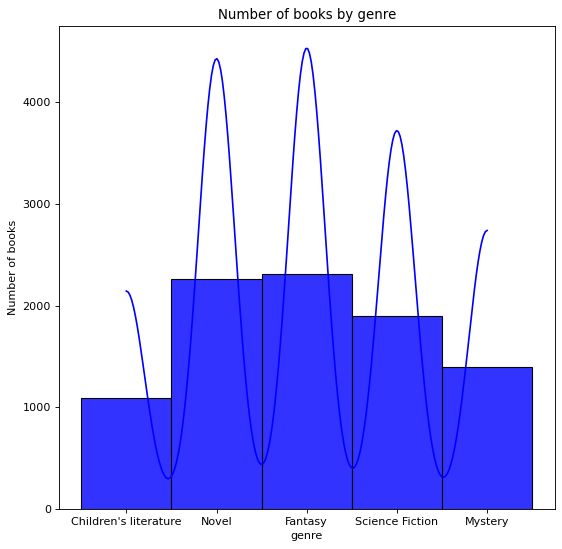

In [9]:
fig = plt.figure(figsize=(8,8), dpi=80)
ax1 = fig.add_subplot()
ax1.set_xlabel('genre')
ax1.set_ylabel('Number of books')
ax1.set_title('Number of books by genre')
sns.histplot(data=genre_books,x='genre',color = 'blue',
alpha = 0.8, bins = 18, kde = True)
plt.show()

 Look at the grapth chart, we can see that ***Novel*** and ***Fantasy*** genre have highest popular book's genre over 2000 books while the rest remained around 1000 to 1800 books  

In [10]:
book_summ = genre_books.groupby(['genre','author']).agg(
    {'title':'count'}
)
author_summ = book_summ.sort_values(by="title",ascending=False).reset_index()
sicenfic_author = author_summ[author_summ['genre']=='Science Fiction']
author_summ
author_summ[author_summ['author']=='Joyce Carol Oates']

,genre,author,title
267,Novel,Joyce Carol Oates,6
2670,Children's literature,Joyce Carol Oates,1
3341,Mystery,Joyce Carol Oates,1


In [11]:
def dfToText(df,genre_name,field):
    words = ''
    for txt in df[df['genre']==genre_name][field].to_list():
        words = words + ''.join(txt)
    words = re.sub(r"[^a-zA-Z0-9\s]"," ", words.lower())
    texts = ''
    for w in words.split(' '): 
        if len(w) > 2:
            texts = texts + ' ' +  w 
    return texts

In [12]:
# Define a function to plot word cloud
def plot_cloud(wordcloud,genre,**kwargs):
    if not bool(kwargs) :
        # Set figure size
        plt.figure(figsize=(40, 30))
        # Display image
        plt.imshow(wordcloud) 
        # No axis details
        plt.axis("off")
        plt.title(label=" Word Cloud for {}".format(genre), fontsize=50)
        plt.tight_layout(pad=2)
        plt.show()
#     else: 
#         ax = kwargs.get('axis')
#         print(type(ax))
#         # Generate word cloud
#         wordcloud = WordCloud(width = 600, height = 300, background_color='white', colormap=color
#                           , collocations=False,contour_color='grey', stopwords = STOPWORDS).generate(texts)
#         # Plot
#         # Display image
#         ax.imshow(wordcloud) 
#         # No axis details
#         plt.axis("off")
#         ax.set_title(label=" Word Cloud for {}".format(genre), fontsize=50)
#         plt.tight_layout(pad=2)
#         plt.show()        

In [13]:
genre_books.genre.value_counts()

Fantasy                  2311
Novel                    2258
Science Fiction          1897
Mystery                  1396
Children's literature    1092
Name: genre, dtype: int64

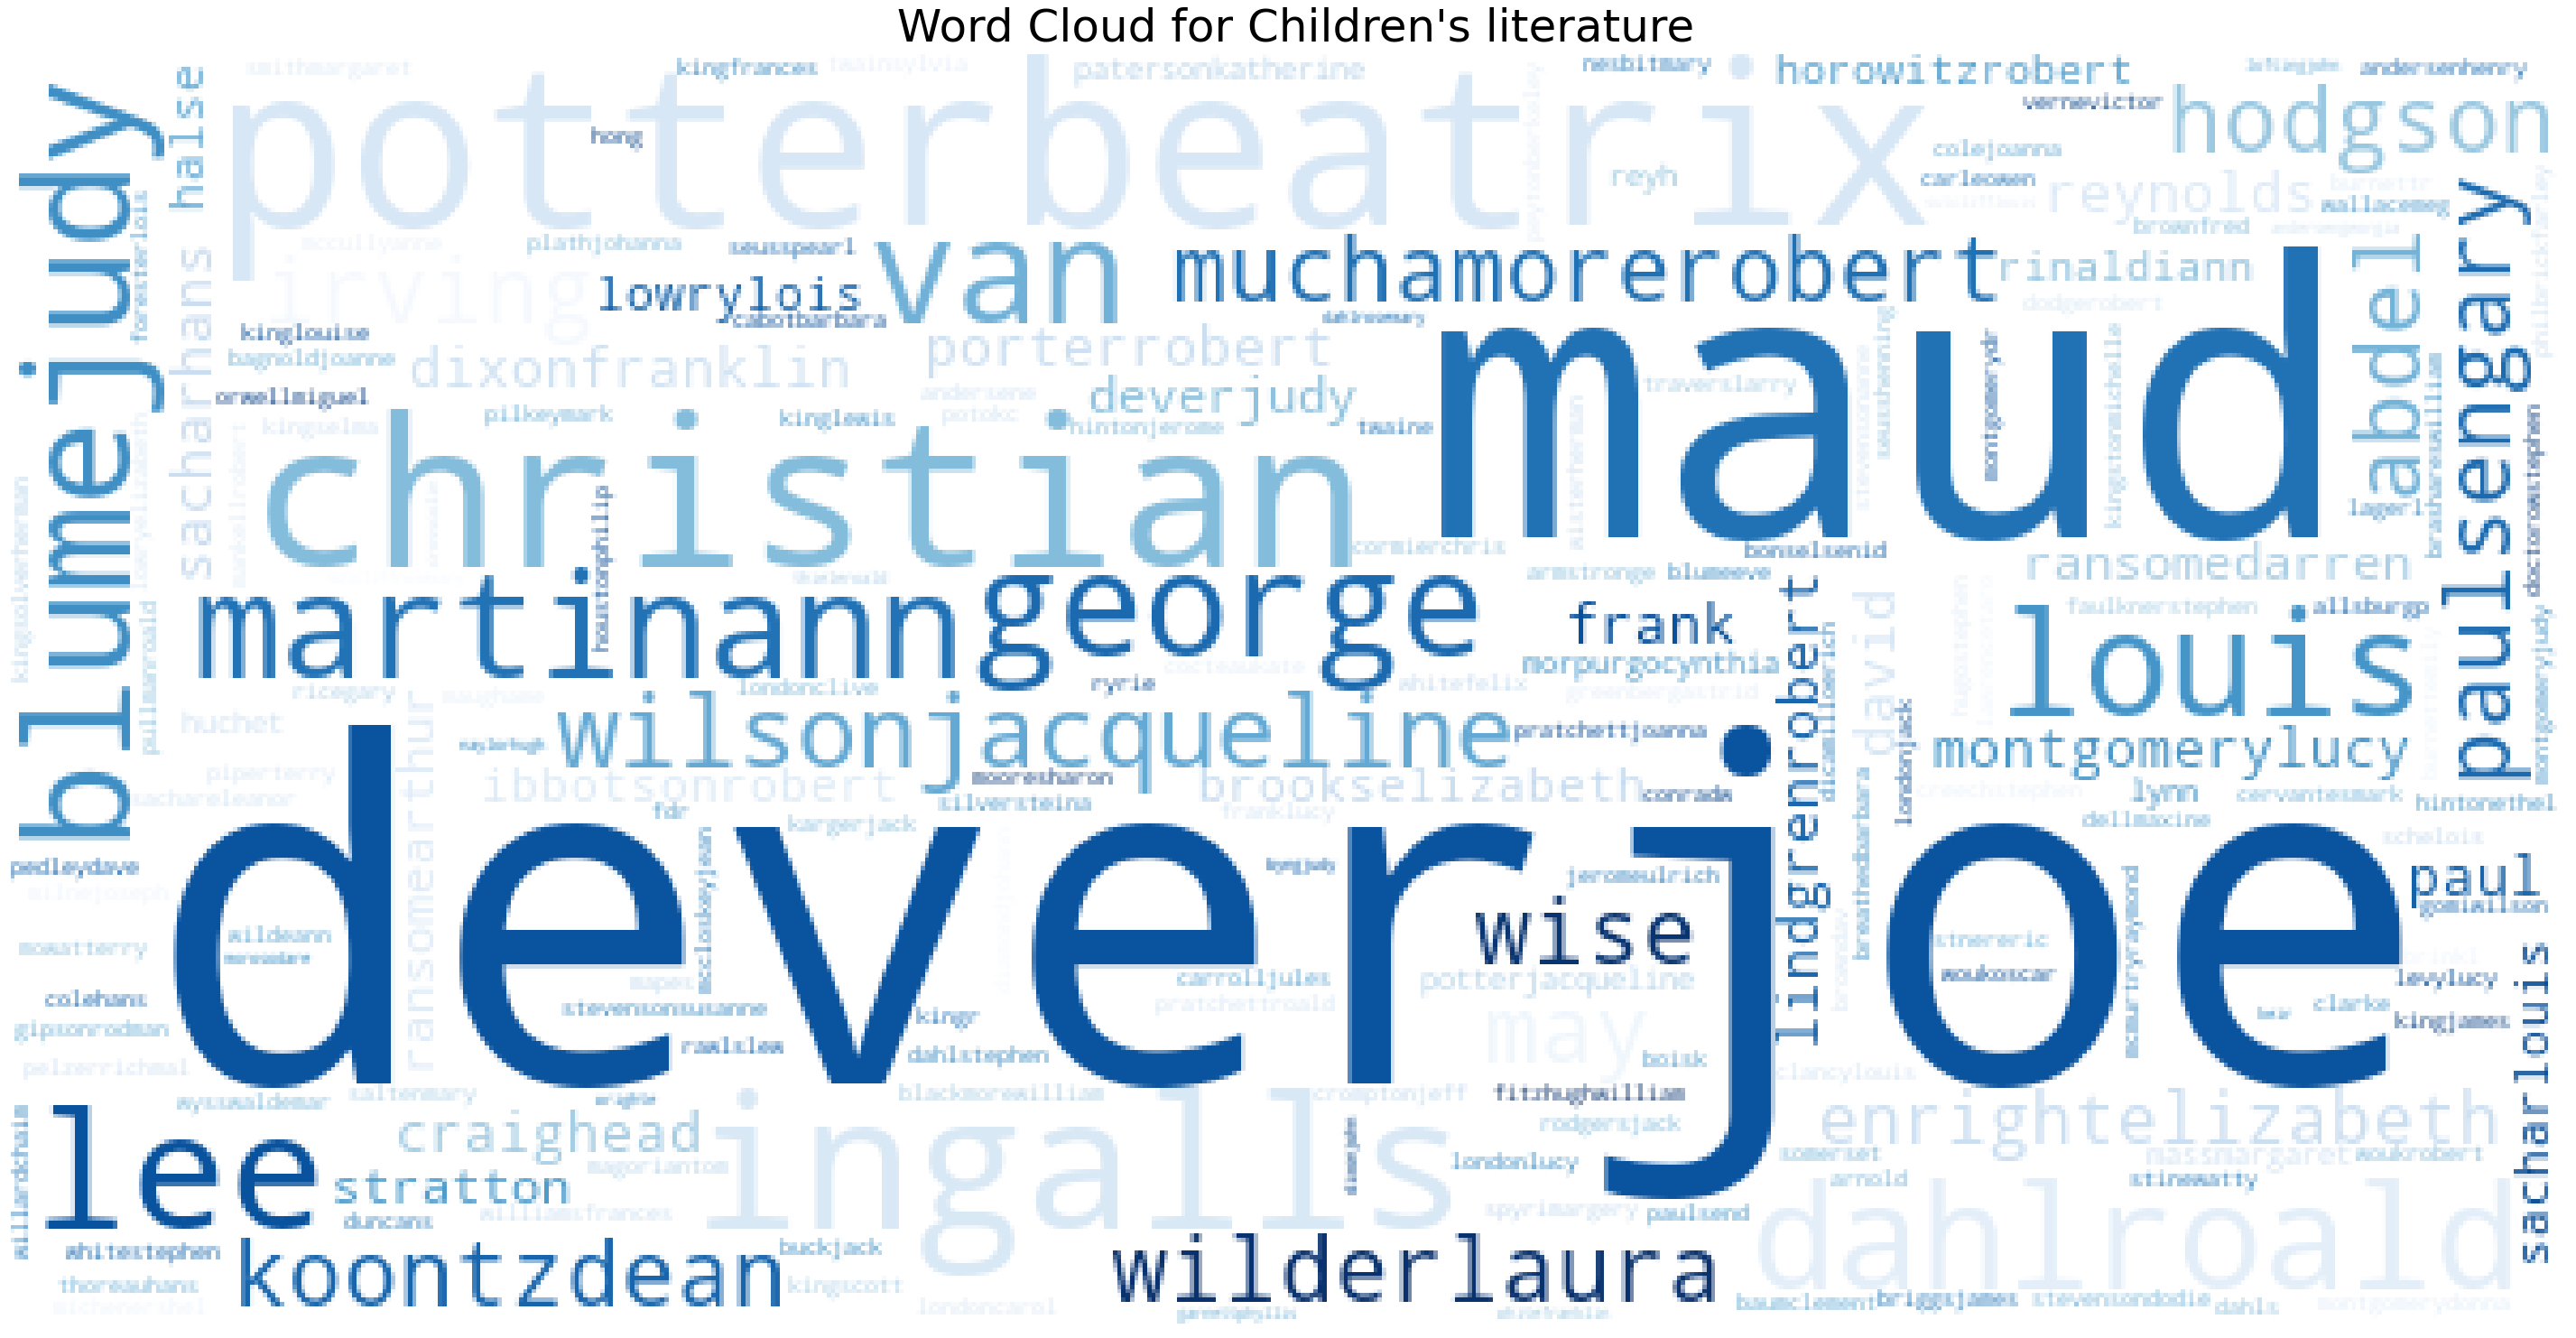

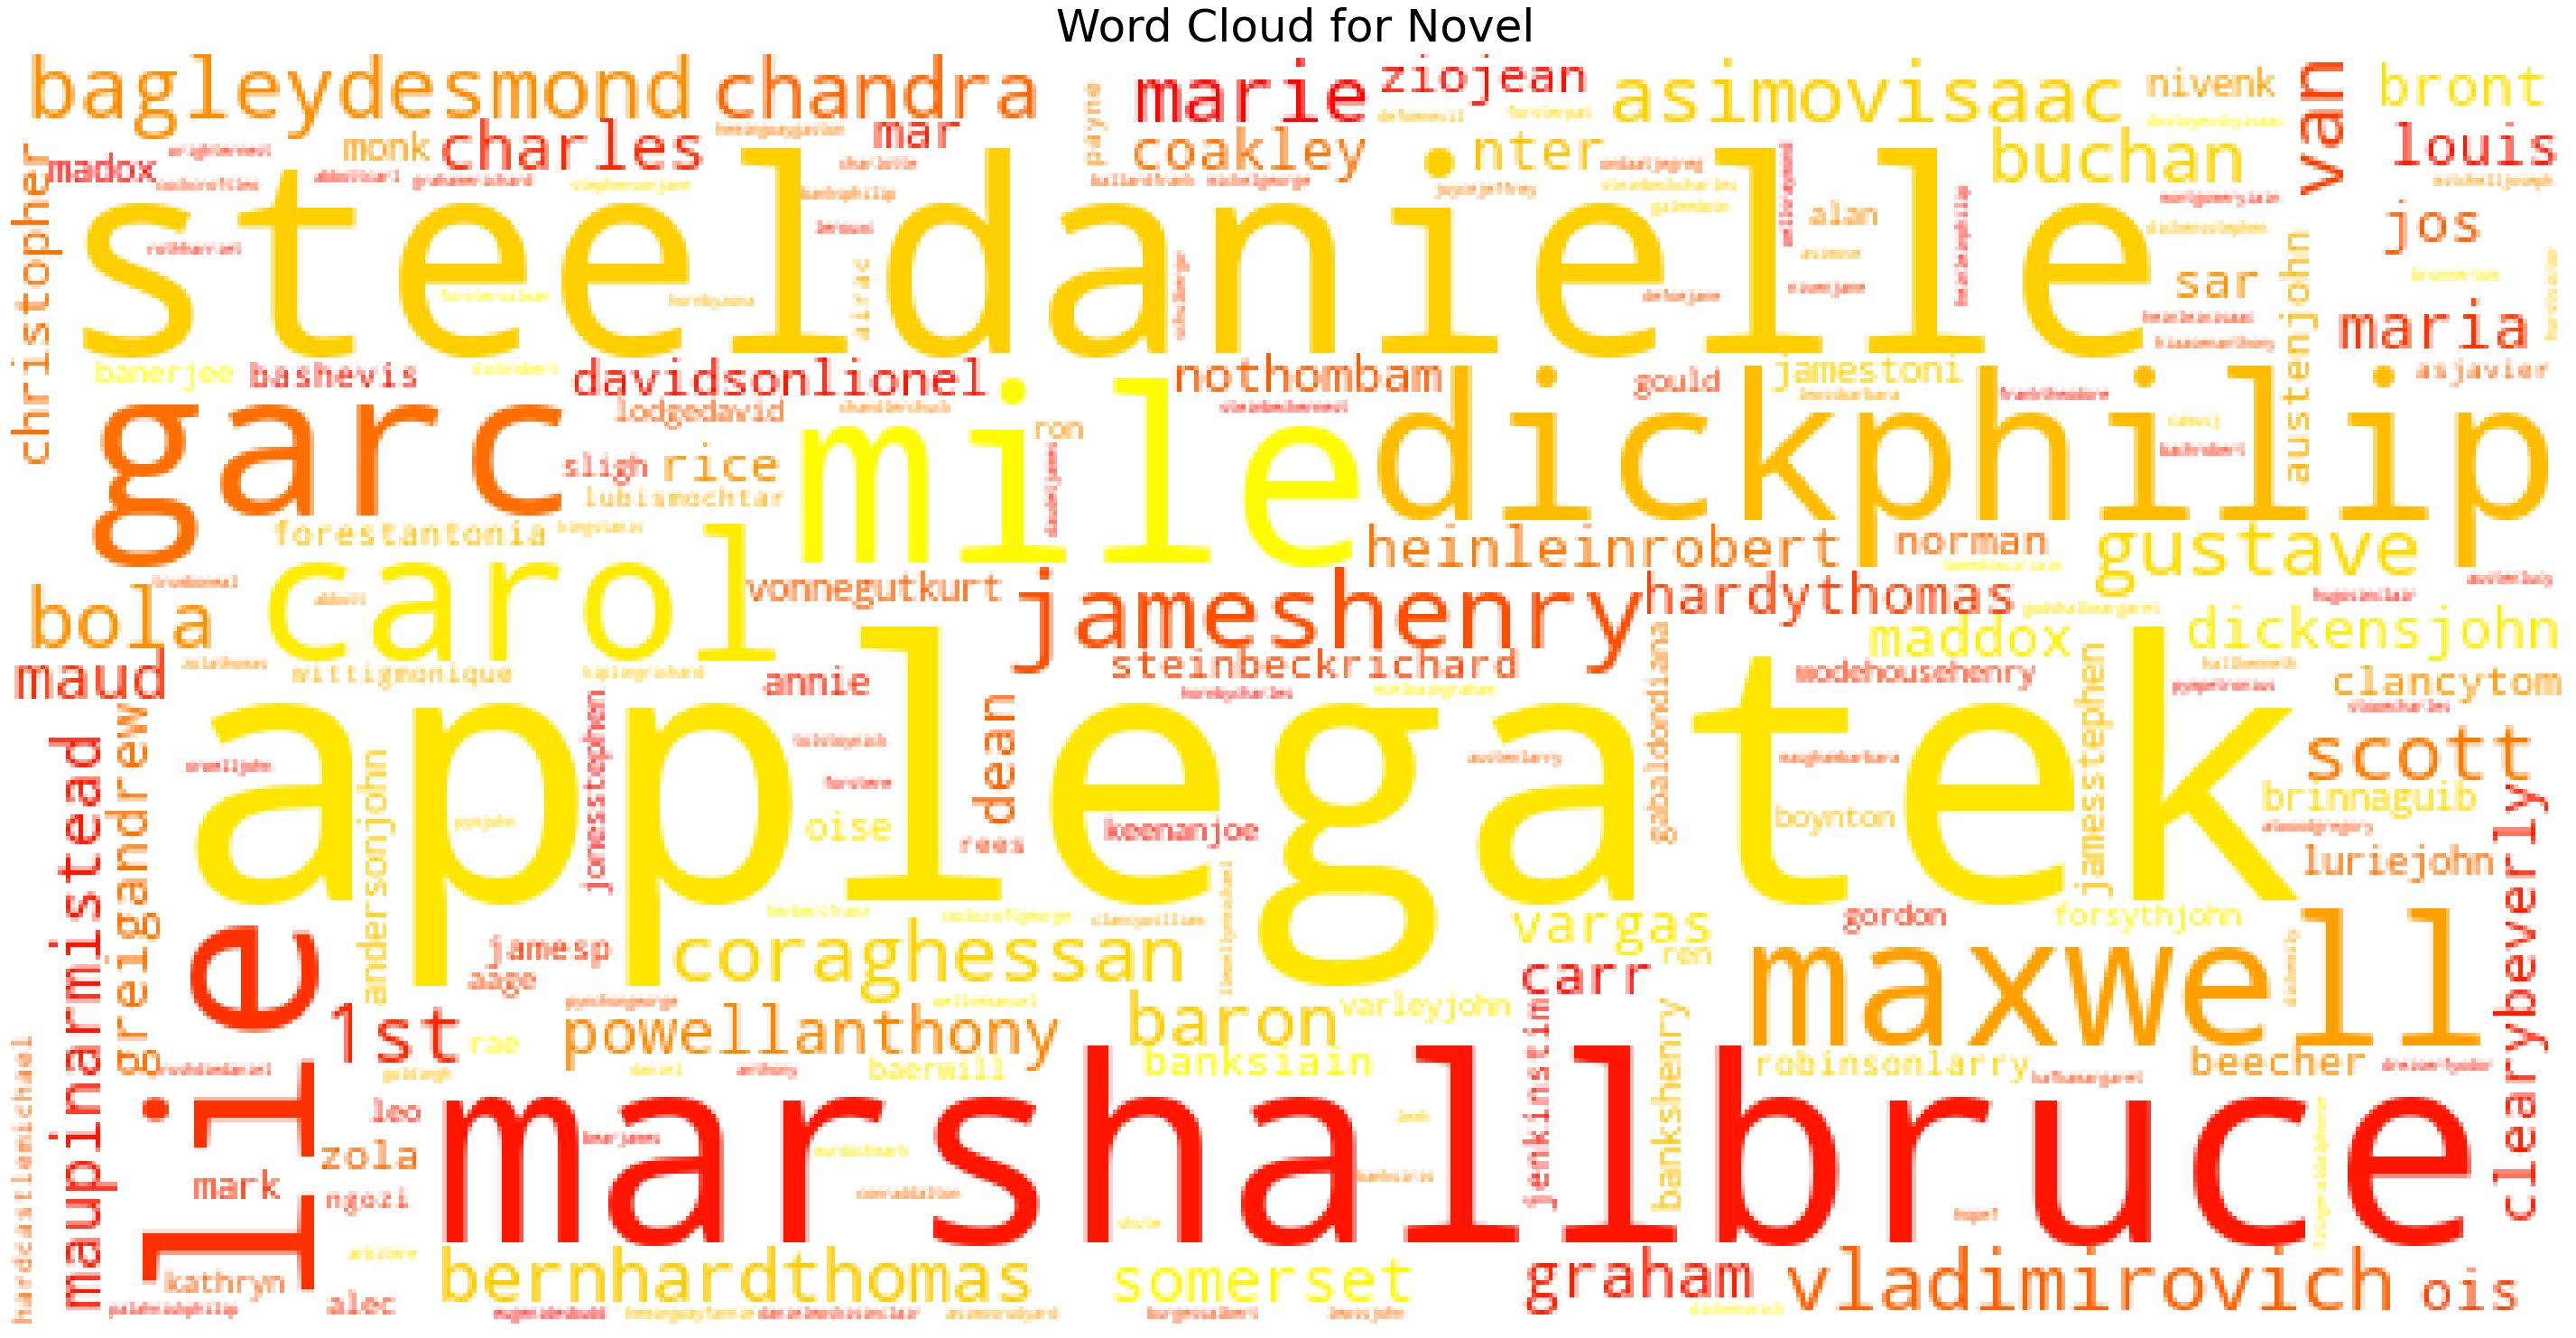

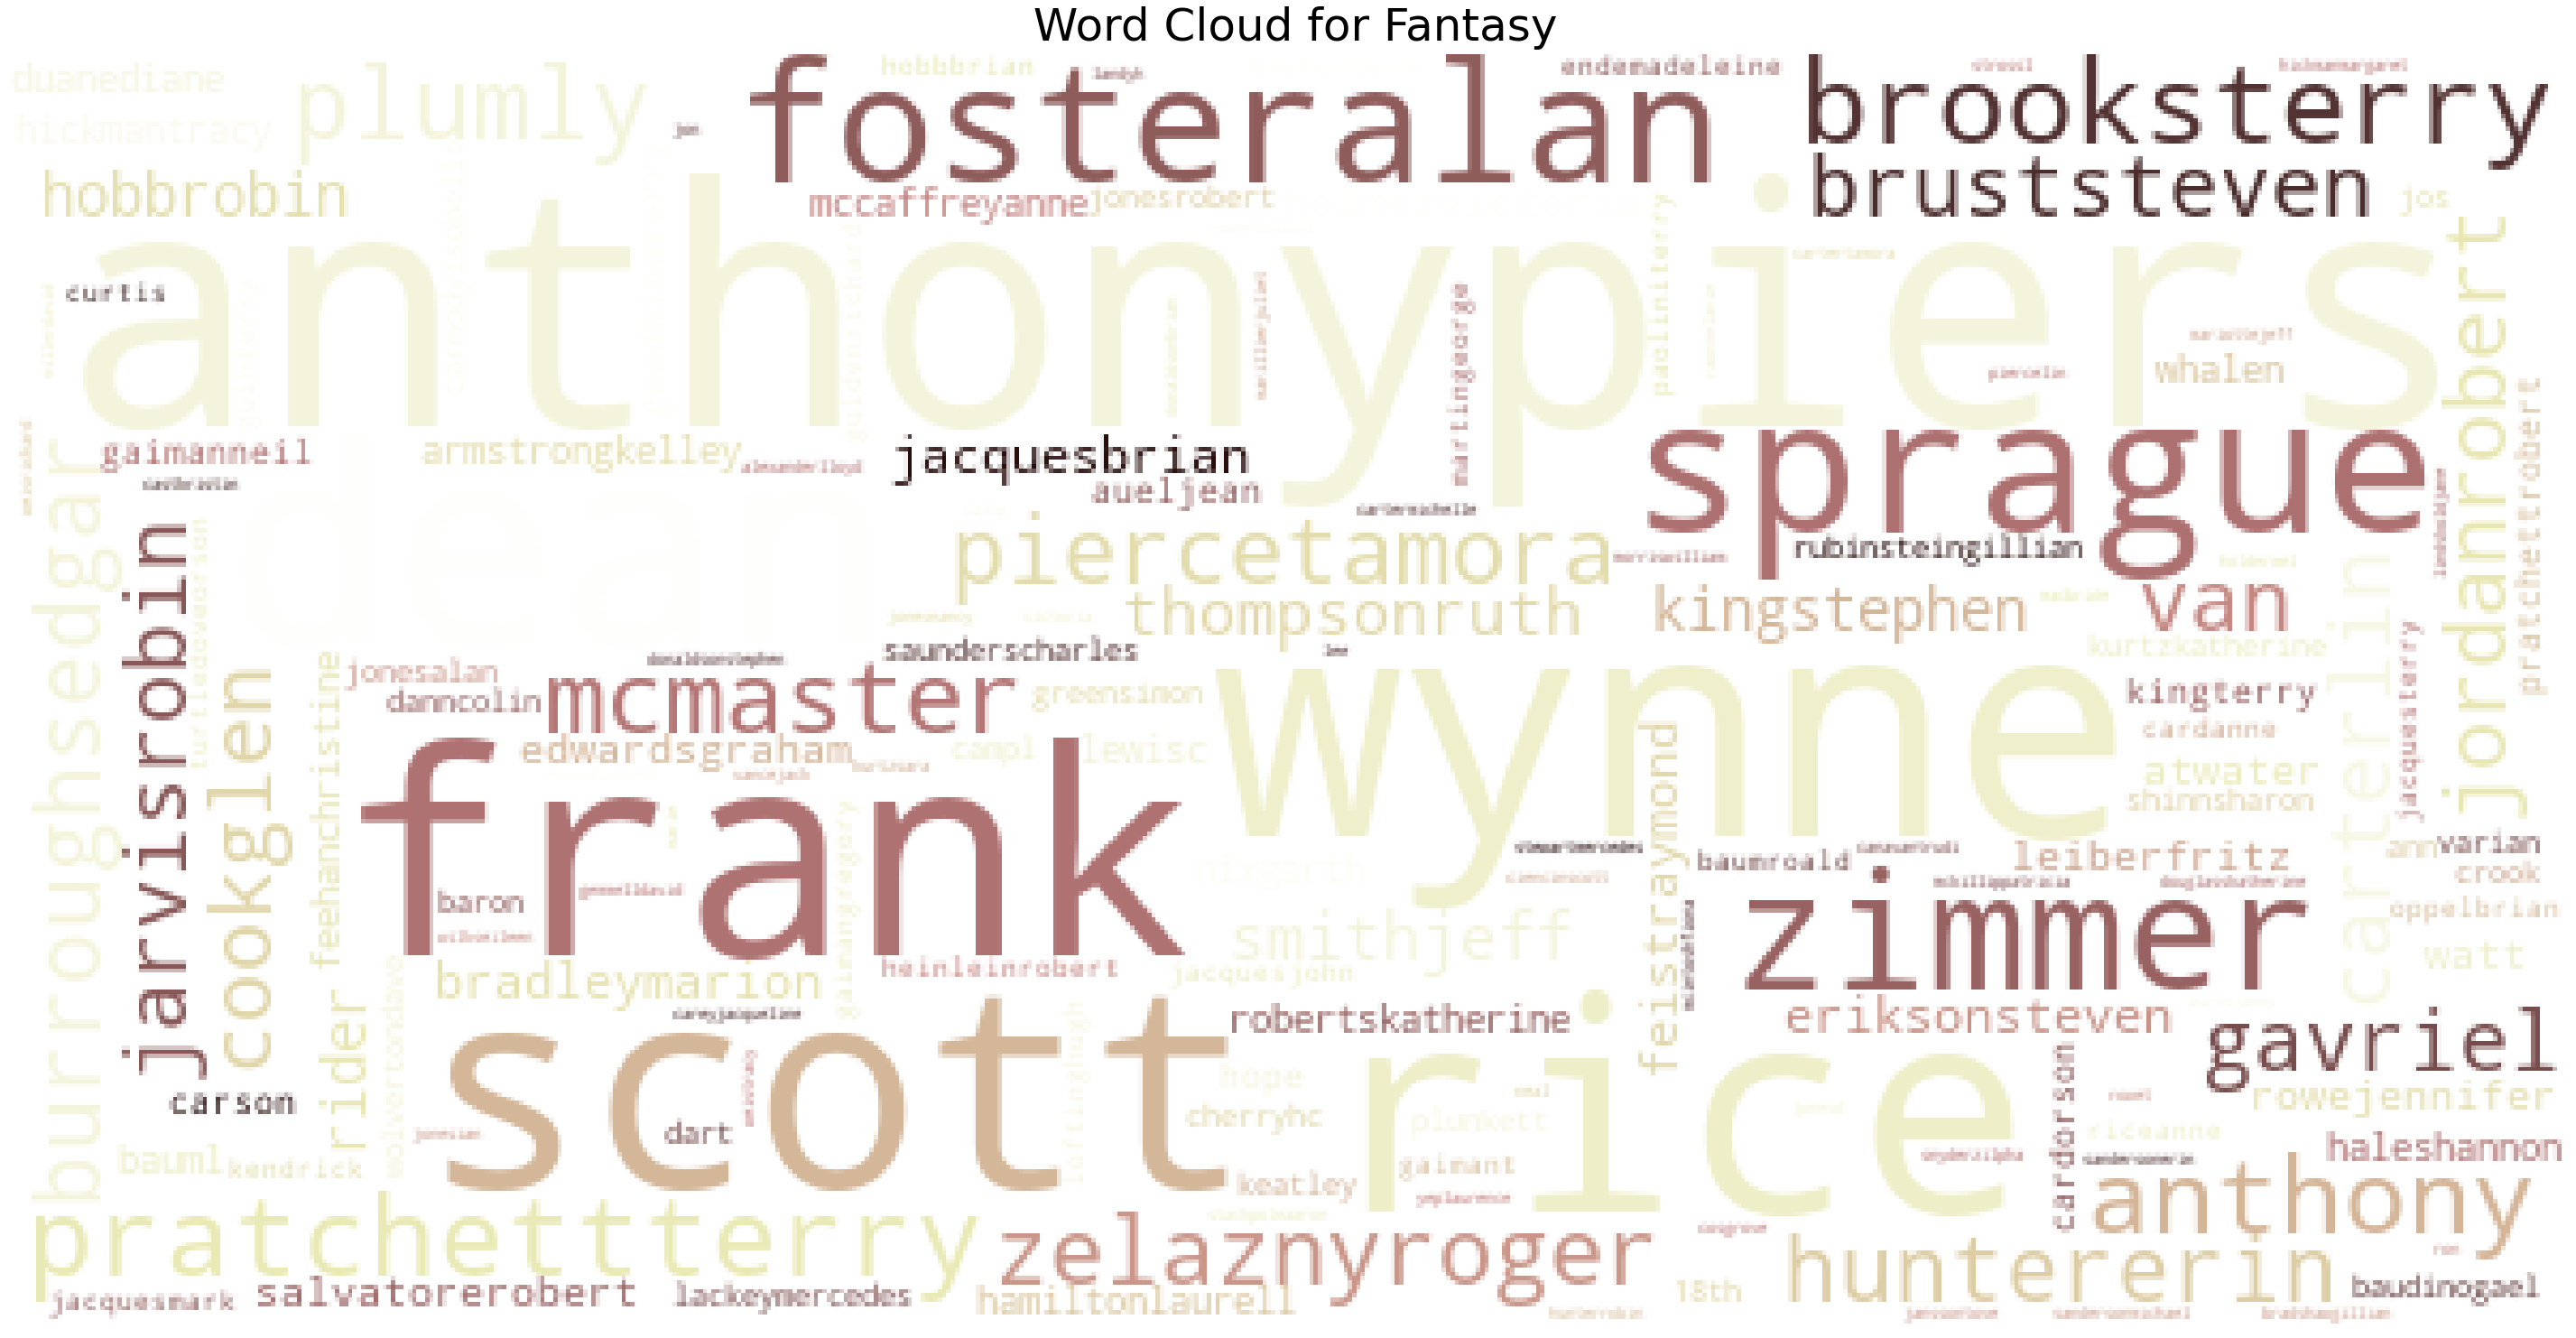

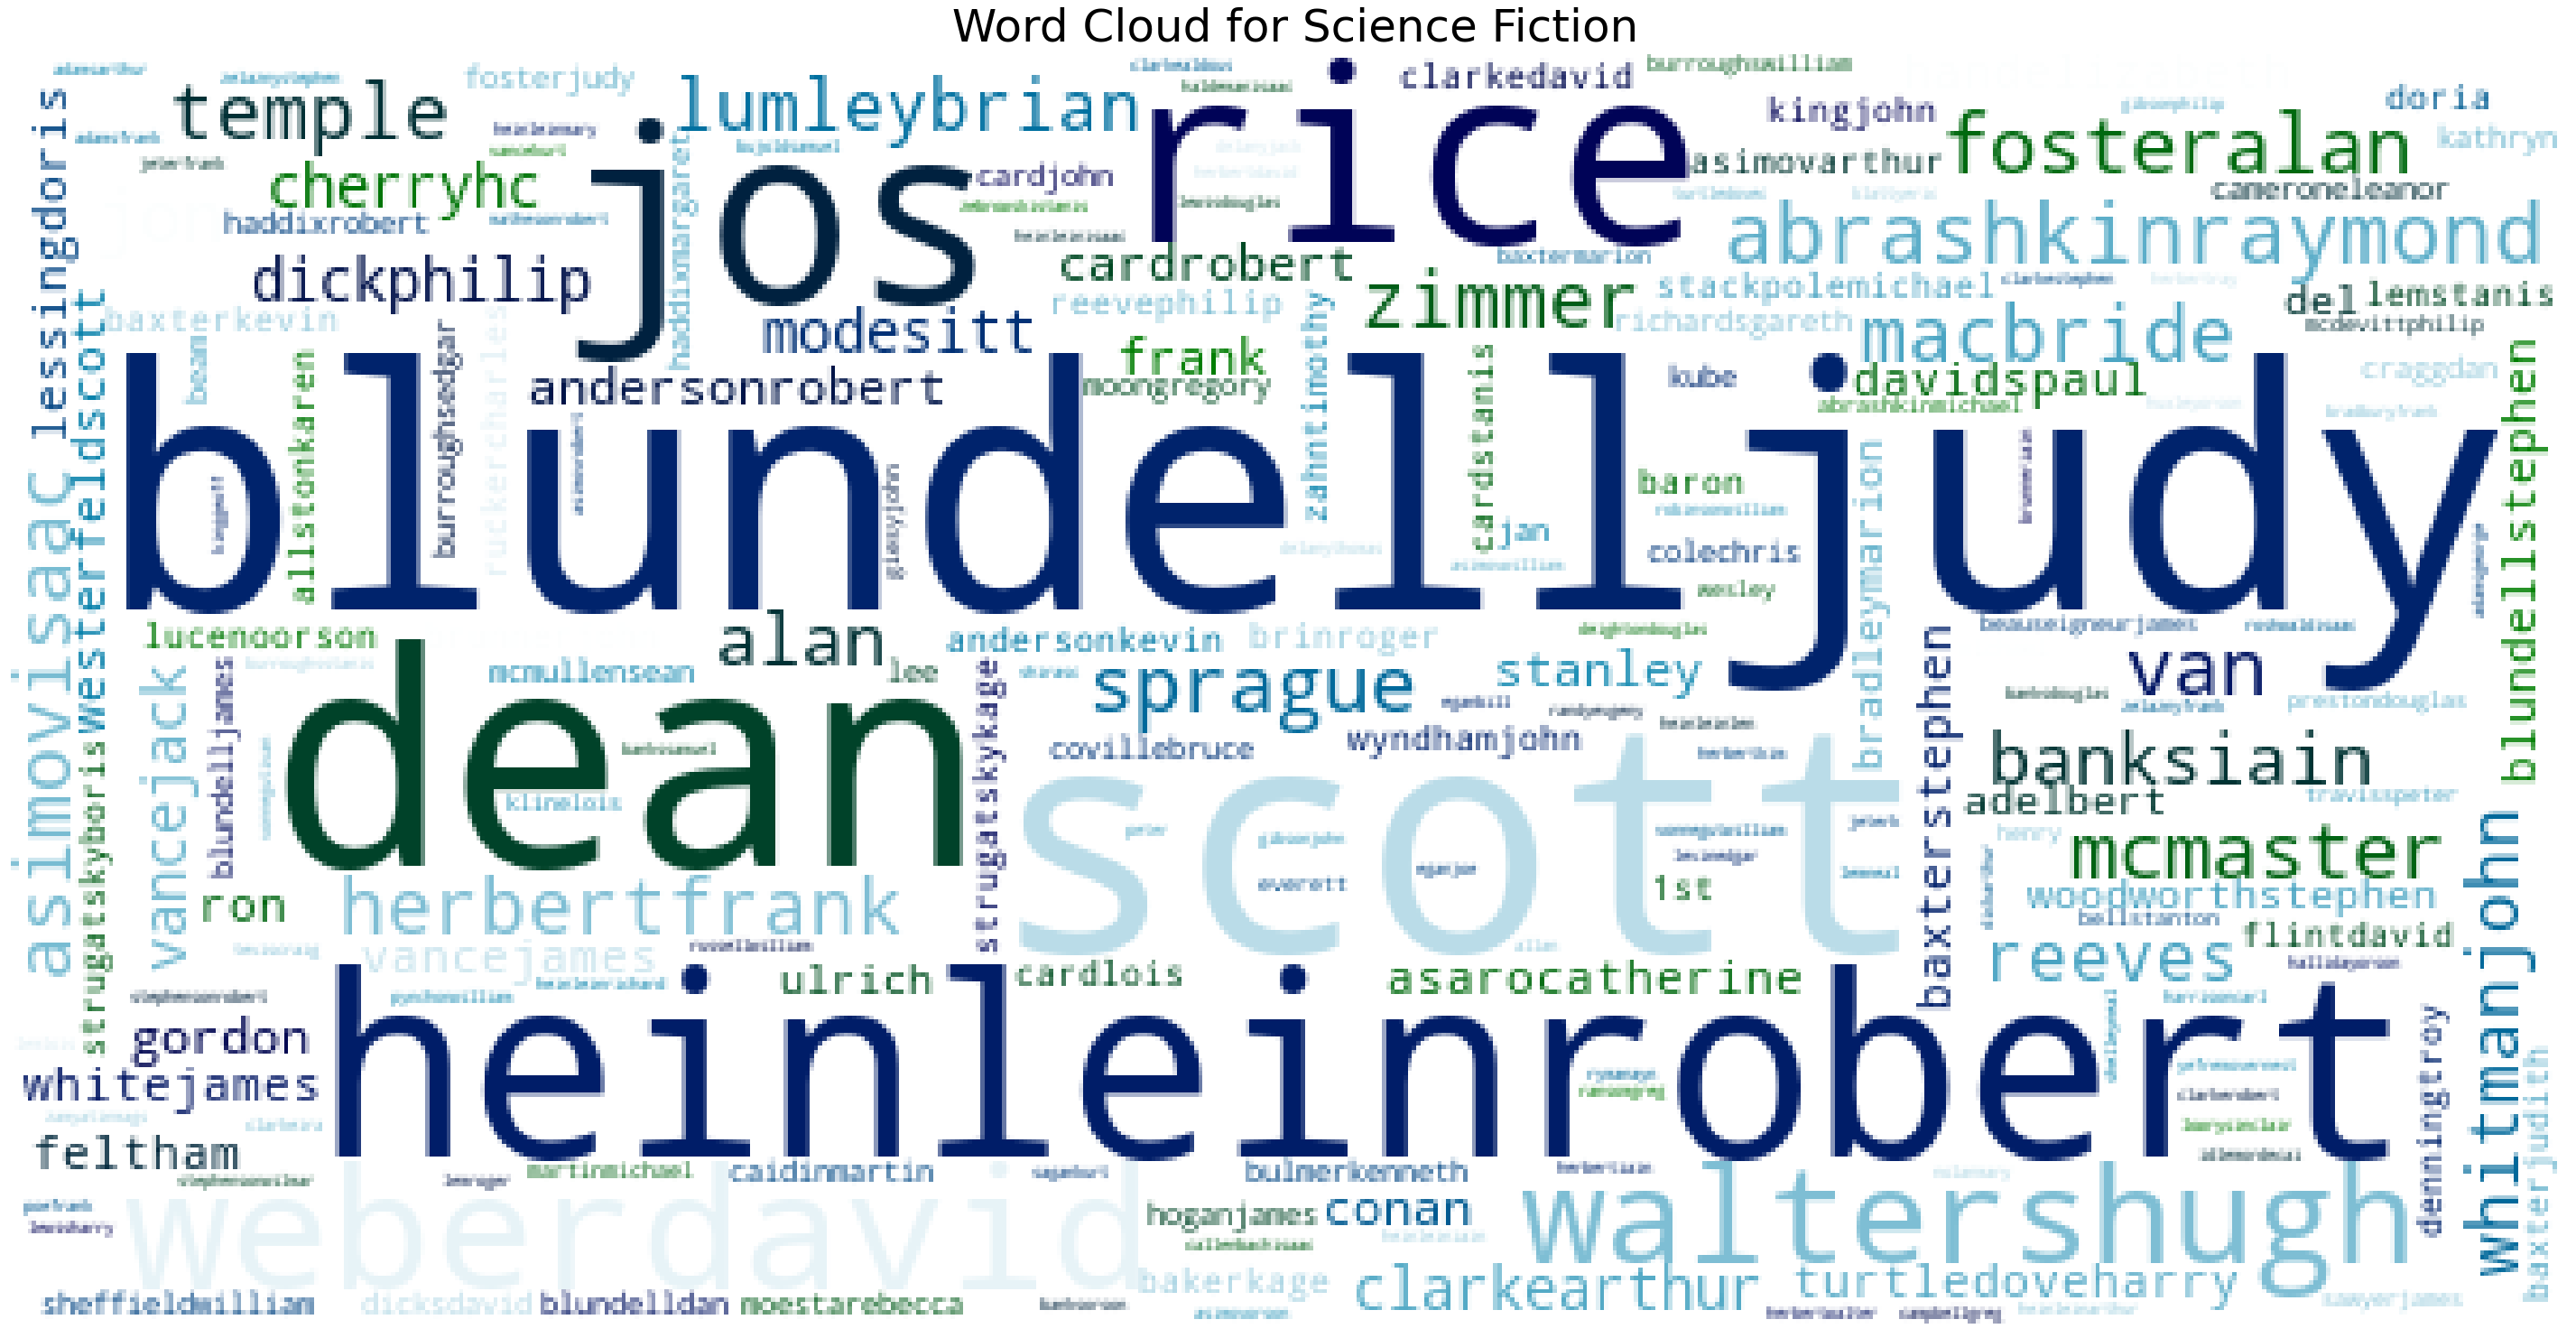

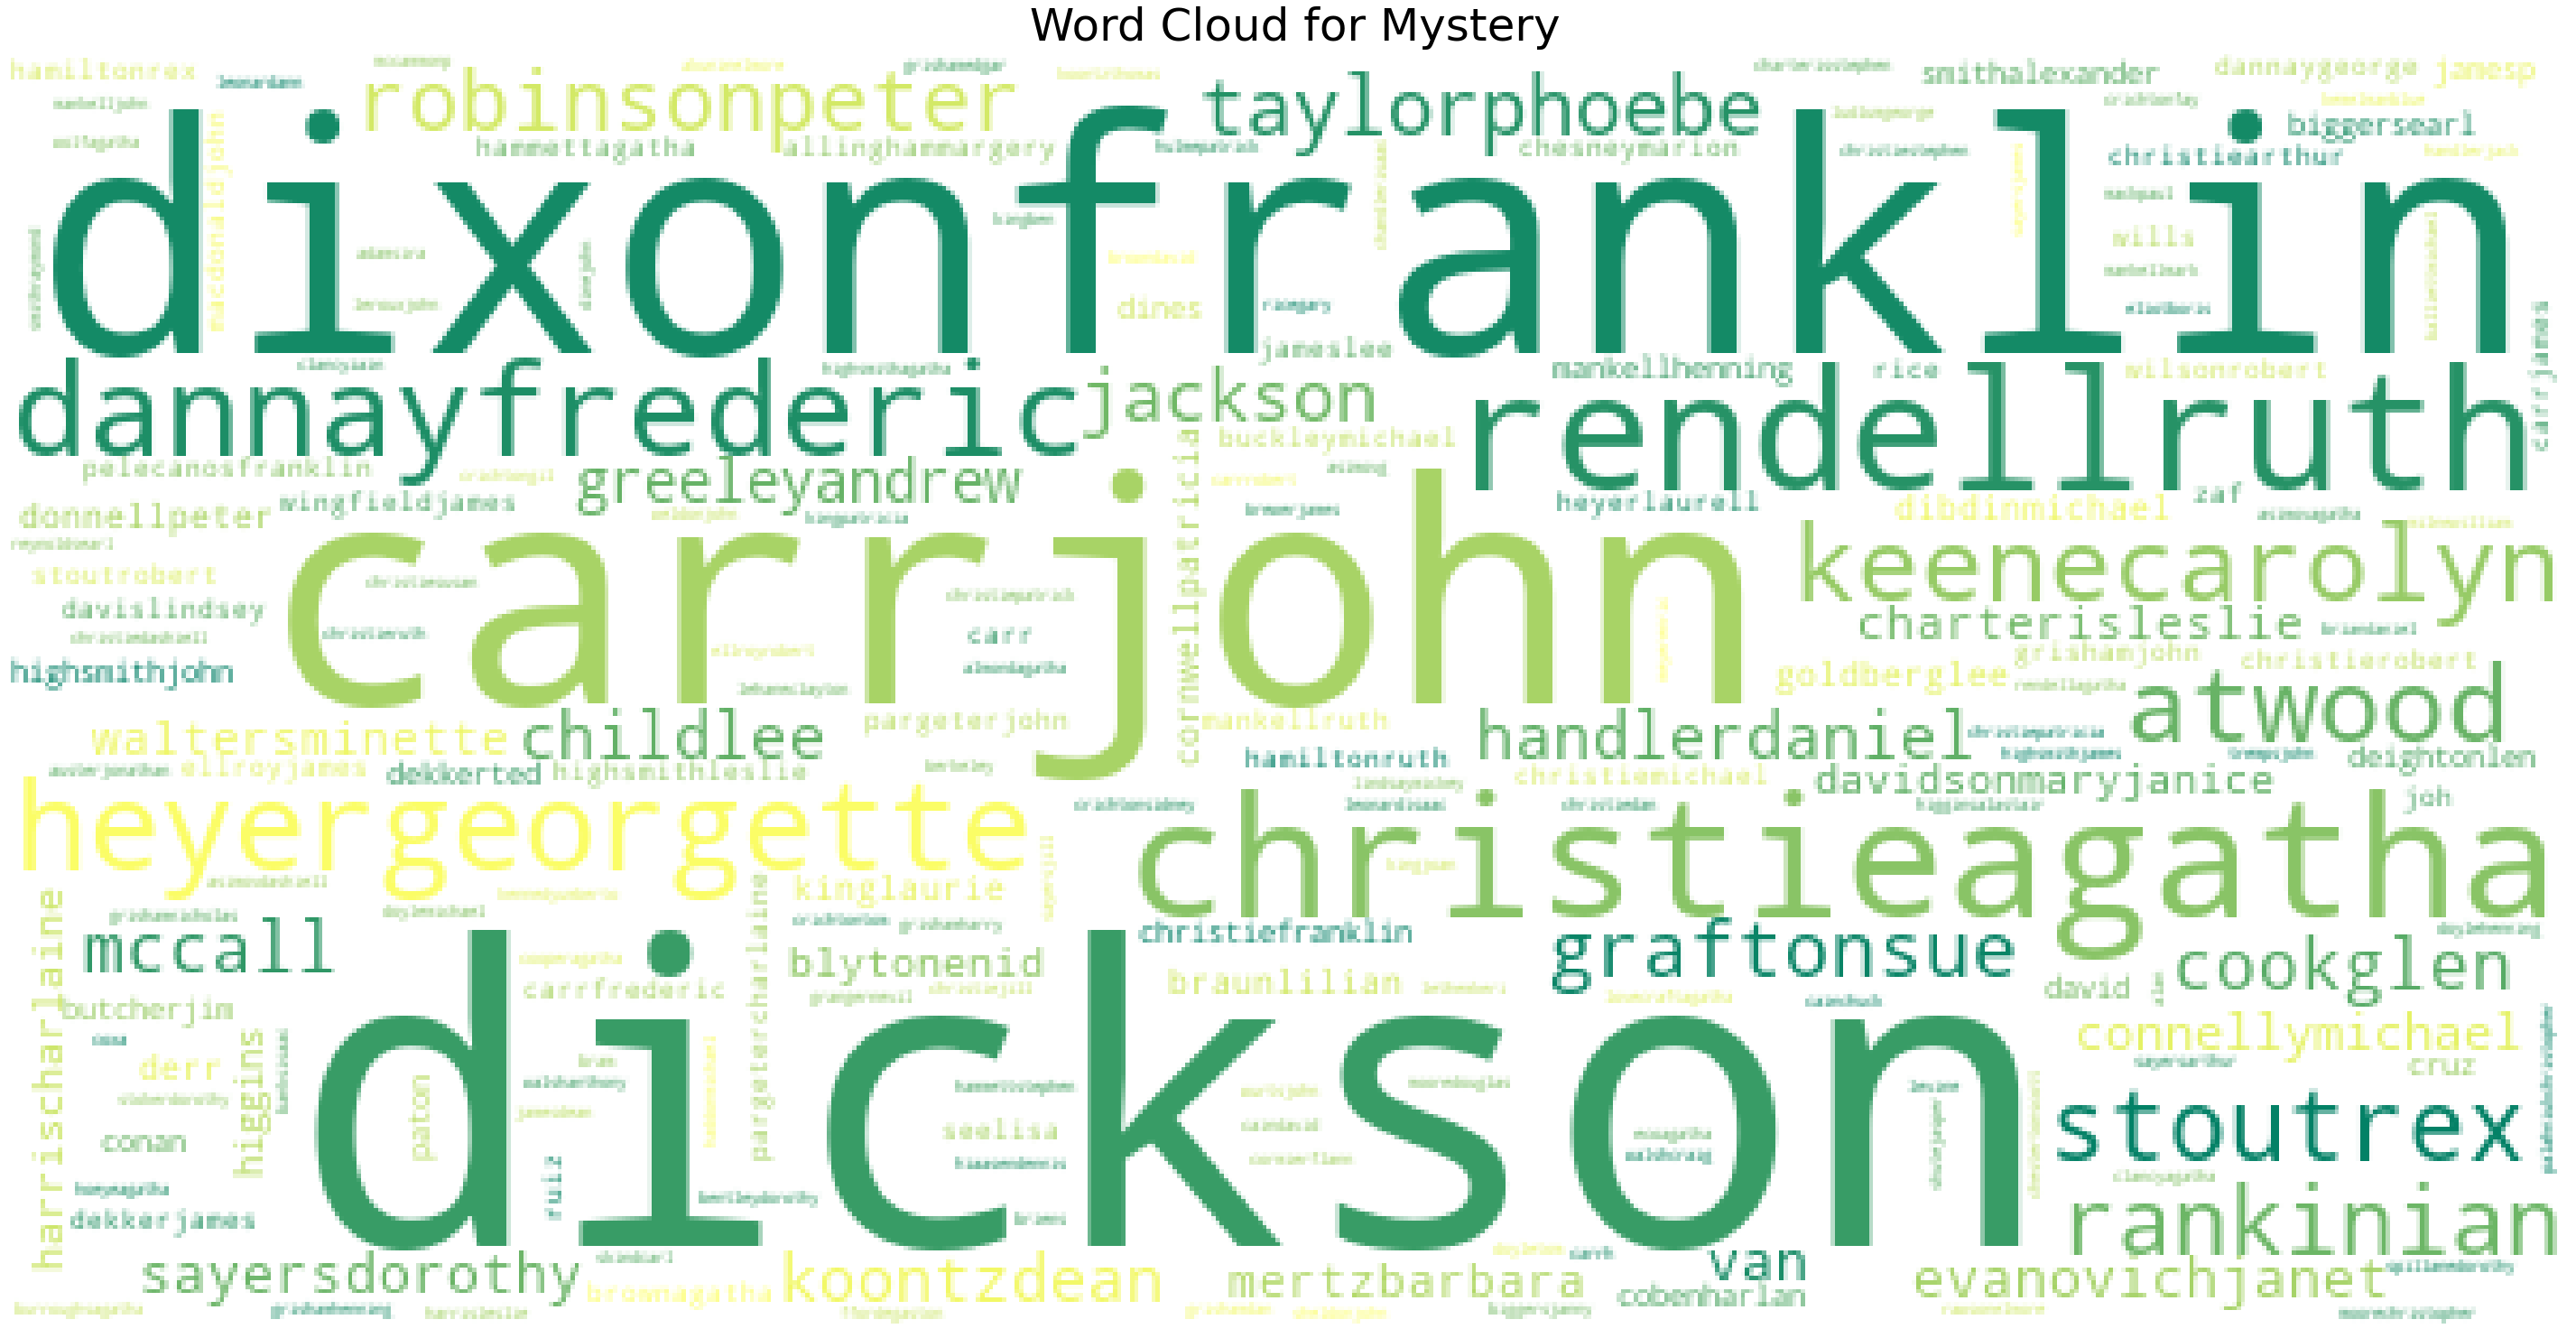

In [14]:
# fig,(ax0,ax1,ax2,ax3,ax4) = plt.subplots(nrows=5,figsize=(40, 30))
colors = ['Blues','autumn','pink_r','ocean_r','summer_r']
zip_lists = [genre_books.genre.unique(),colors]
# fig,ax = plt.subplots(ncols=1)
for genre,color in zip(*zip_lists):
#     genre = 'Science Fiction'
    texts = dfToText(genre_books,genre,'author')
# Generate word cloud
    wordcloud = WordCloud(width = 600, height = 300, background_color='white', colormap=color
                      , collocations=False,contour_color='grey', stopwords = STOPWORDS).generate(texts)
# Plot
    plot_cloud(wordcloud,genre)

### From the wordcount charts, we can see that:
* `Chidren's literature`: **deverjoe, maud, and potterbeatrix** are the most popular author. 
* `Novel`: **appleagatex, marshallbruce and stelldanielle** are the most common author. 
* `Fantasy`: **anthonypiers wyne and dean** are the most wellknown wellknown author.
* `Science Fiction`: the most popular author are  **blundelljudy, scott and weberdavid**  
* `Mystery`: the most wellknownpopular author are **dickson, dixonfranklin and carrjohn**.  

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
data = genre_books
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent
data['summary'] = data['summary'].str.lower()
data['summary'] = data['summary'].apply(cleanHtml)
data['summary'] = data['summary'].apply(cleanPunc)
data['summary'] = data['summary'].apply(keepAlpha)

In [16]:
import nltk
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
data['summary'] = data['summary'].apply(removeStopWords)

In [17]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
genre_books['summary'] = genre_books['summary'].apply(stemming)

In [18]:
books_df1=pd.DataFrame(genre_books,columns=['title', 'author', 'date', 'genres', 'summary'])

In [19]:
books_df1['summary']=data["summary"]

In [20]:
books_df1

,title,author,date,genres,summary
0,Animal Farm,George Orwell,1945-08-17,NaN,old major old boar manor farm call anim farm m...
1,A Clockwork Orange,Anthony Burgess,1962,NaN,alex teenag live near futur england lead gang ...
2,The Plague,Albert Camus,1947,NaN,text plagu divid part town oran thousand rat i...
4,A Fire Upon the Deep,Vernor Vinge,,NaN,novel posit space around milki way divid conce...
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,NaN,ged young boy gont larger island north archipe...
...,...,...,...,...,...
16525,Beautiful Creatures,Margaret Stohl,2009-12-01,NaN,beauti creatur set fiction gatlin south caroli...
16526,Beautiful Chaos,Gary Russell,,NaN,return home strang thing start occur small tow...
16531,Guardians of Ga'Hoole Book 4: The Siege,Helen Dunmore,2004-05-01,NaN,receptio
16532,The Casual Vacancy,J. K. Rowling,2012-09-27,NaN,novel split part first depict aftermath death ...


In [21]:
le = preprocessing.LabelEncoder()
genre_books['genre_dummy'] = le.fit_transform(genre_books['genre'].values)
genre_books.head()

,title,author,date,summary,genre,genre_dummy
0,Animal Farm,George Orwell,1945-08-17,old major old boar manor farm call anim farm m...,Children's literature,0
1,A Clockwork Orange,Anthony Burgess,1962,alex teenag live near futur england lead gang ...,Novel,3
2,The Plague,Albert Camus,1947,text plagu divid part town oran thousand rat i...,Novel,3
4,A Fire Upon the Deep,Vernor Vinge,,novel posit space around milki way divid conce...,Fantasy,1
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,ged young boy gont larger island north archipe...,Fantasy,1


In [22]:
# genre = 'Novel'
# texts = dfToText(genre_books,genre,'author')
# # Generate word cloud
# wordcloud = WordCloud(width = 800, height = 300, random_state=1, background_color='salmon', colormap='Pastel1'
#                       , collocations=False, stopwords = STOPWORDS).generate(texts)
# # Plot
# plot_cloud(wordcloud,genre)

## 4.Model Training
<a id="Training"></a>

### Selecting two significant features associated with the analysis above, including an author and a summary.

In [23]:
data = genre_books[['summary','author','genre_dummy']]
data['books_df1'] = dfToText(genre_books,genre,'author')

### It is clear that the problem is one of classification, then I utilize three top models such as Navies Bayes, Logistic Regression and [XGBoost](https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-390929969673:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1028581&gclid=CjwKCAjw-e2EBhAhEiwAJI5jg1vt4gv28aj0rii-QQhTbJI8AsV6rgiXwuvsUE7bwJN5JOr3vntXfxoCFeAQAvD_BwE)

In [24]:
train_fields = genre_books[['summary']]

In [25]:
train_fields['summary'].to_numpy()[:10]

array(['old major old boar manor farm call anim farm meet compar human parasit teach anim revolutionari song beast england major die young pig snowbal napoleon assum command turn dream philosophi anim revolt drive drunken irrespons mr jone farm renam anim farm adopt command anim ism import anim equal snowbal attempt teach anim read write food plenti farm run smooth pig elev posit leadership set asid special food item ostens person health napoleon take pup farm dog train privat napoleon snowbal struggl leadership snowbal announc plan build windmil napoleon dog chase snowbal away declar leader napoleon enact chang govern structur farm replac meet committe pig run farm use young pig name squealer mouthpiec napoleon claim credit windmil idea anim work harder promis easier live windmil violent storm anim find windmil annihil napoleon squealer convinc anim snowbal destroy although scorn neighbour farmer suggest wall thin snowbal becom scapegoat napoleon begin purg farm dog kill anim accus co

In [26]:
# column_trans.get_feature_names()

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer

# And finally TfidfVectorizing. You can also take CountVectorizer, but I prefer Tfidf as it has masses of advantages.

# tfidf = TfidfVectorizer() #max_features=500
# # train_fields['summary'] = tfidf.fit_transform(genre_books['leaned_summary'])
# train_fields = tfidf.fit_transform(genre_books['leaned_summary'])
tfidf = TfidfVectorizer(max_features=1000,stop_words=stop_words)
tf_train_data = pd.concat([data['summary'], data['author']])
trained_tf_idf_transformer = tfidf.fit_transform(tf_train_data)
data['tf_idf1'] = tfidf.transform(data['summary'].to_numpy())
data['tf_idf2'] = tfidf.transform(data['author'].to_numpy())
data_for_model = data[['tf_idf1', 'tf_idf2', 'genre_dummy']]
# from sklearn.model_selection import train_test_split
X = data_for_model[['tf_idf2', 'tf_idf2']].to_numpy()
Y = data_for_model['genre_dummy'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=142)

vect = TfidfVectorizer()

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


# column_trans = ColumnTransformer(
#     [
#     ('author', OneHotEncoder(),['author']),
#     ('leaned_summary', TfidfVectorizer(max_features=1000), 'leaned_summary'),
#     ],
#     remainder='drop')
column_trans = ColumnTransformer(
    [
    ('author', OneHotEncoder(),['author']),
    ('summary', TfidfVectorizer(max_features=1000), 'summary'),
    ],
    remainder='drop')
column_trans.fit(data)
X = column_trans.transform(data).toarray()
X[:2]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.02801055,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02050022,
        0.        ]])

In [29]:
# clf1.fit(X_train, y_train)
# print(accuracy_score(clf1.predict(X_train),y_train))
# y_pred_MNB = clf1.predict(X_test)
# print(accuracy_score(y_pred_MNB, y_test))

In [30]:
# from sklearn.model_selection import train_test_split
y = data['genre_dummy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### MODEL 
clf1 = MultinomialNB()
clf1.fit(X_train, y_train)

## Navie bayes 
y_pred_MNB = clf1.predict(X_test)
print(cross_val_score(clf1, X, y, cv=3))
print(accuracy_score(y_pred_MNB, y_test))
scores_new = {}
scores_new['MultinomialNB'] = accuracy_score(y_pred_MNB, y_test)

## XGB 
clf2 = XGBClassifier(eval_metric='rmse', use_label_encoder=False)
clf2.fit(X_train, y_train)

y_pred_XGB = clf2.predict(X_test)
print(cross_val_score(clf2, X, y, cv=3))
print(accuracy_score(y_pred_XGB, y_test))

scores_new['XGB'] = accuracy_score(y_pred_XGB, y_test)
## LogisticRegression
clf3 = LogisticRegression(random_state=0)
clf3.fit(X_train, y_train)

y_pred_lr = clf3.predict(X_test)
print(cross_val_score(clf3, X, y, cv=3))
print(accuracy_score(y_pred_lr, y_test))

scores_new['LR'] = accuracy_score(y_pred_lr, y_test)

[0.66465662 0.73065327 0.68331099]
0.7453936348408711
[0.63953099 0.67169179 0.64812332]
0.6733668341708543
[0.6881072  0.74036851 0.6689008 ]
0.7359017308766053


In [31]:
scores_new 

{'MultinomialNB': 0.7453936348408711,
 'XGB': 0.6733668341708543,
 'LR': 0.7359017308766053}

In [32]:
# define Classifiers with optimum hyper_param
from sklearn.linear_model import LogisticRegression

clf1 = MultinomialNB()
clf2 = XGBClassifier(eval_metric='rmse', use_label_encoder=False)
clf3 = LogisticRegression(random_state=0)
# append models and run in for loop for cv
models = []
models.append(('MultinomialNB' , clf1))
models.append(('XGB', clf2))
models.append(('LogisticRegression', clf3))

results = []
names = []
scoring =  ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
for name, model in models:
    cv = KFold(n_splits=5, shuffle=True , random_state=42)
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    results.append(name)
results =  results[::2] # use the numeric part

#average of each metrics
test_accuracy = []
for i in range (len(names)):
    test_accuracy.append(results[i]['test_accuracy'].mean())
    
test_f1 = []
for i in range (len(names)):
    test_f1.append(results[i]['test_f1_macro'].mean())  
    
test_pre = []
for i in range (len(names)):
    test_pre.append(results[i]['test_precision_macro'].mean())

test_rec = []
for i in range (len(names)):
    test_rec.append(results[i]['test_recall_macro'].mean())
    
 #Model Merices plot
category_names = names
result = {"accuracy_score": test_accuracy, 'f1score':    test_f1, 'precision': test_pre, 'recall':    test_rec,  }

In [33]:
result

{'accuracy_score': [0.7442501770179264, 0.6818189020833528, 0.747711431147045],
 'f1score': [0.7258749546730576, 0.6716735651785962, 0.7425172021952104],
 'precision': [0.7715394263999369, 0.683098875615578, 0.7525892743816154],
 'recall': [0.7120136728151597, 0.6648920570051444, 0.7359430094740093]}

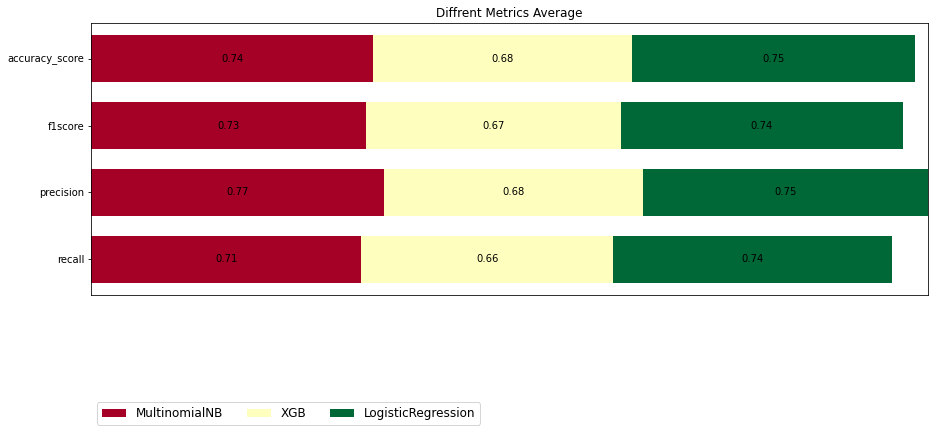

In [34]:
def plot_compareModel(result, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(result.keys())
    data = np.array(list(result.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0, 1, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
   

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.7,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color =  'k'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(np.around(c,decimals = 2)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, -0.5),
              loc='lower left', fontsize='large')
    ax.set_title('Diffrent Metrics Average', loc='center')
    fig.savefig('fname_macro', dpi=300)
    return fig, ax


plot_compareModel(result, category_names)
plt.show()

## 5.Model Evaluation
<a id="Evaluation"></a>

Finally, evaluate and compare the learned predictive models.

### Confusion matrix


Classification Report

                       precision    recall  f1-score   support

Children's literature       0.70      0.63      0.66       225
              Fantasy       0.74      0.74      0.74       446
              Mystery       0.84      0.78      0.81       295
                Novel       0.70      0.74      0.72       444
      Science Fiction       0.71      0.76      0.73       381

             accuracy                           0.74      1791
            macro avg       0.74      0.73      0.73      1791
         weighted avg       0.74      0.74      0.74      1791



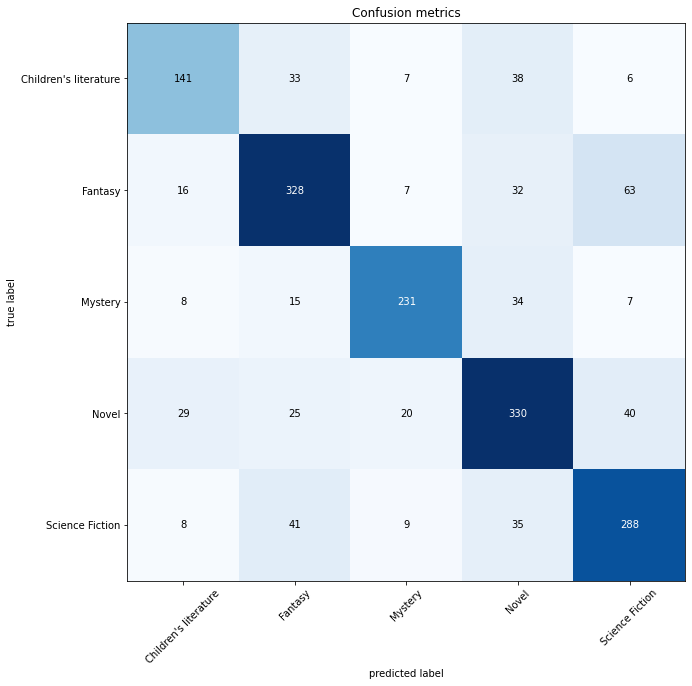

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
clf3 = LogisticRegression(random_state=0) # Logistic Regression
clf3.fit(X_train, y_train)
class_names = ["Children's literature", 'Fantasy', 'Mystery', 'Novel',
       'Science Fiction']
y_pred_lr = clf3.predict(X_test)
print('\nClassification Report\n')
print(classification_report(y_test, y_pred_lr, target_names=class_names))

cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred_lr, 
                      binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm,figsize=(10,15),class_names=class_names)

ax.set_title("Confusion metrics")


plt.show()

#### Comments: 
From the confusion metrics, we can see that:
* `Mystery` label was the highest accuracy at around **84%**, **78%** and **81%** respectively in F1 and precision score, recall score and f-1 score while the figure for "Children's literature" was the lowest at around **70%**, **63%** and **66%** respectively
*  The model was most frequently incorrect in predicting that 'Fantasy' would be classified as 'Science Fiction' and vice versa.

### ROC curve

In [36]:

# Binarize the output
y_class = label_binarize(y, classes=[0, 1, 2,3,4])
n_classes = y_class.shape[1]
print(X[:10],y[:10])
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=128)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(clf3) # Logistic Regression 
y_score = classifier.fit(X_train, y_train).predict(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

[[0.         0.         0.         ... 0.         0.02801055 0.        ]
 [0.         0.         0.         ... 0.         0.02050022 0.        ]
 [0.         0.         0.         ... 0.         0.02692159 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.03900323 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] 0     0
1     3
2     3
4     1
6     1
8     4
9     4
20    3
21    4
23    4
Name: genre_dummy, dtype: int32


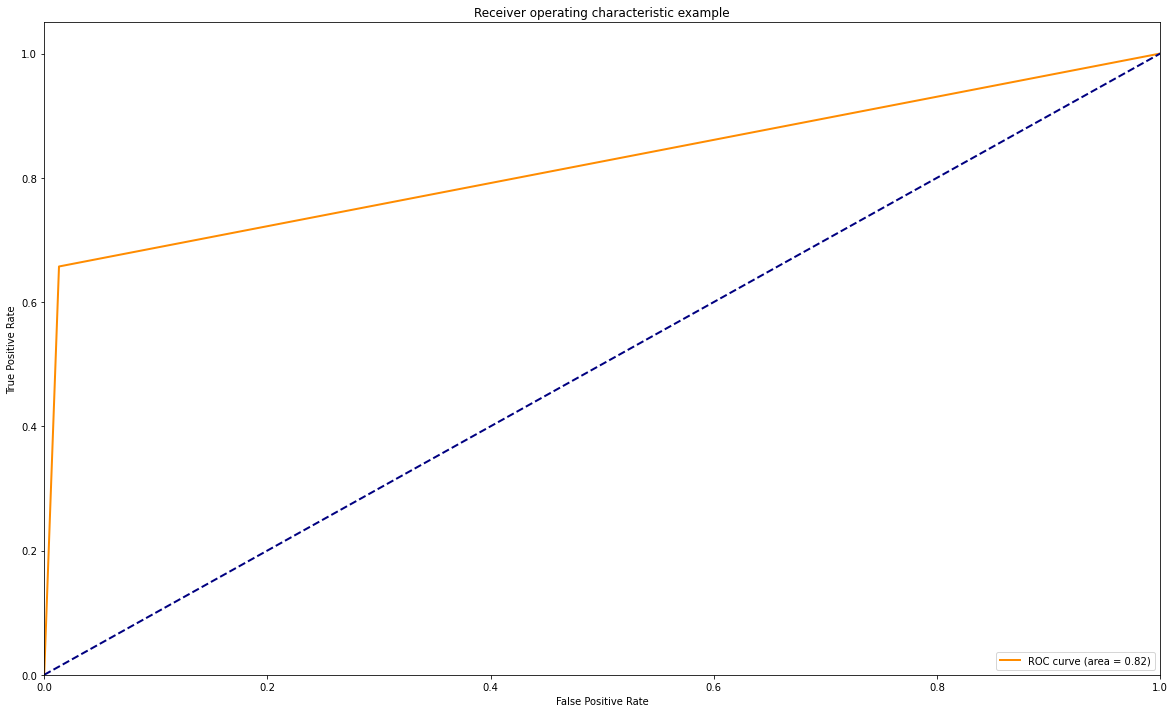

In [37]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure(figsize=(20,12))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### COMMENTS: 
* ROC value was **0.82**, indicating that it makes an accurate prediction about genre'book classification.

## Finished Porfolio 3